In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Flatten
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    Input,
    concatenate,
)
from keras.optimizers import Adam

2024-02-24 04:18:37.290870: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 04:18:37.545751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 04:18:37.545817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 04:18:37.574324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 04:18:37.682041: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 04:18:37.683099: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df = pd.read_csv("./flipkart_product.csv", encoding="ISO-8859-1")
df.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [3]:
for column in df.columns:
    df[column] = df[column].str.replace("?", "")
    df[column] = df[column].str.replace("ÿ", "")
    df[column] = df[column].str.replace("", "")
df.head()

,ProductName,Price,Rate,Review,Summary
0,"Candes 12 L Room/Personal Air Cooler(White, Bl...","3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,"Candes 12 L Room/Personal Air Cooler(White, Bl...","3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,"Candes 12 L Room/Personal Air Cooler(White, Bl...","3,999",3,Fair,The quality is good but the power of air is de...
3,"Candes 12 L Room/Personal Air Cooler(White, Bl...","3,999",1,Useless product,Very bad product it's a only a fan
4,"Candes 12 L Room/Personal Air Cooler(White, Bl...","3,999",3,Fair,Ok ok product


## Preprocessing


In [7]:
X = df["Review"].astype(str)
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
y = df["Rate"].apply(lambda x: 1 if x > 3 else 0).values


# Tokenize the text data

max_words = 5000

tokenizer = Tokenizer(num_words=max_words, split=" ")

tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

X = pad_sequences(X)


# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Build the CNN model

embedding_dim = 100

input_dim = min(len(tokenizer.word_index) + 1, max_words)

## CNN Model


In [8]:
cnn_model = Sequential()
cnn_model.add(
    Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=X.shape[1])
)
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
cnn_model.add(MaxPooling1D(pool_size=2))

2024-02-24 04:19:10.332579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 04:19:10.349074: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## LSTM Model


In [9]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(
    Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=X.shape[1])
)
lstm_model.add(LSTM(100))

## Combine models


In [10]:
cnn_flatten = Flatten()(cnn_model.output)

combined_model = concatenate([cnn_flatten, lstm_model.output], axis=-1)

# Add a Dense layer before the final output layer
combined_model = Dense(64, activation="relu")(combined_model)

# Output layer
output = Dense(1, activation="sigmoid")(combined_model)

# Define the combined model
model = Model(inputs=[cnn_model.input, lstm_model.input], outputs=output)

## Compile the model


In [11]:
model.compile(
    loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"]
)

history_callback = History()

# Train the model
training_history = model.fit(
    [X_train, X_train],
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=([X_test, X_test], y_test),
    callbacks=[history_callback],
)
history = training_history.history

Epoch 1/5
2374/2374 [==============================] - 101s 41ms/step - loss: 0.0931 - accuracy: 0.9598 - val_loss: 0.0797 - val_accuracy: 0.9669
Epoch 2/5
2374/2374 [==============================] - 97s 41ms/step - loss: 0.0798 - accuracy: 0.9656 - val_loss: 0.0781 - val_accuracy: 0.9668
Epoch 3/5
2374/2374 [==============================] - 98s 41ms/step - loss: 0.0789 - accuracy: 0.9659 - val_loss: 0.0817 - val_accuracy: 0.9665
Epoch 4/5
2374/2374 [==============================] - 100s 42ms/step - loss: 0.0785 - accuracy: 0.9660 - val_loss: 0.0790 - val_accuracy: 0.9669
Epoch 5/5
2374/2374 [==============================] - 99s 42ms/step - loss: 0.0783 - accuracy: 0.9660 - val_loss: 0.0790 - val_accuracy: 0.9669


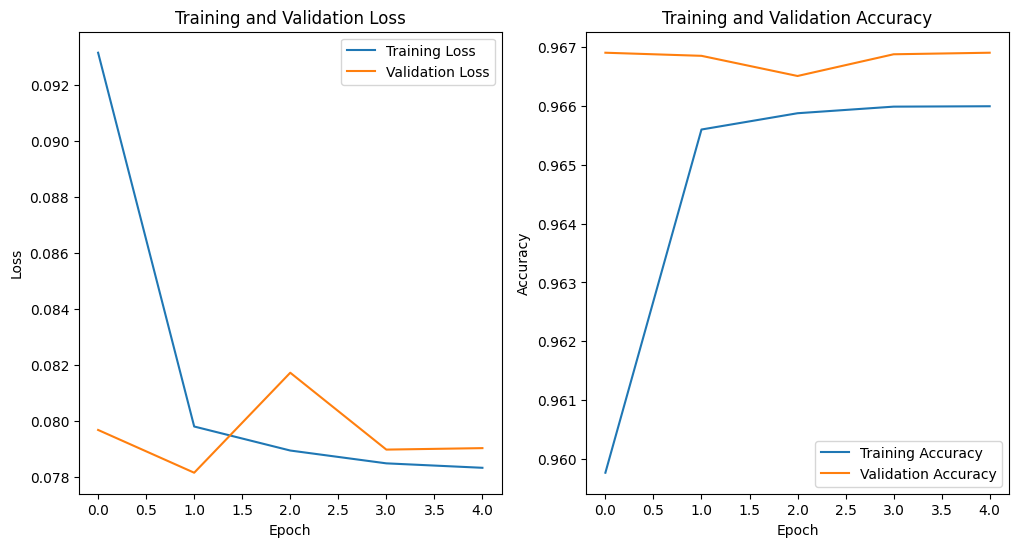

In [12]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [19]:
new_reviews = ["This product is great!", "Not satisfied with the quality."]
sequences = tokenizer.texts_to_sequences(new_reviews)

max_sequence_length = 24

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

predictions = model.predict([padded_sequences, padded_sequences])

for review, prediction in zip(new_reviews, predictions):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {prediction[0]} (Probability)")
    print("---------------")

1/1 [==============================] - 0s 41ms/step
Review: This product is great!
Predicted Sentiment: 0.865235447883606 (Probability)
---------------
Review: Not satisfied with the quality.
Predicted Sentiment: 0.9880196452140808 (Probability)
---------------


In [21]:
model.save('sentiment_analysis_model.h5')

/home/user/code/projects/marketing-sentiment-analysis/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
